In [1]:
%matplotlib inline

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.patheffects as path_effects
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from IPython.display import HTML

import numpy as np
import math
import re

from scipy.stats import gaussian_kde

import baltic as bt
import bezier as bz


In [2]:
ancestry = {}  # Initialize an empty ancestry dictionary
# ancestry={gene:{tip:{t:[] for t in timeline} for tip in tips} for gene in ['genome','gp']}
timeline=[]
tips=[]
# Define the path
path = "C:/Users/iblag/Documents/flud/segment4_final.combined.trees.ancestry.log"

ancestry={'genome':{}}
for gene in ['genome']:
    indices={}
    for line in open(path,'r'):
        l=line.strip('\n').split('\t')
        if l[0]=='state':
            header={x:i for i,x in enumerate(l) if x!='state'}
            header=l[1:]

            for e,entry in enumerate(header):
                cerberus=re.search('([A-Za-z\/\|\_\.\-0-9]+)\_([0-9\.]+)$',entry)
                tip=cerberus.group(1)
                timeslice=cerberus.group(2)

                if tip not in indices:
                    indices[tip]={}

                if timeslice not in indices[tip]:
                    indices[tip][timeslice]=e+1

                if timeslice not in timeline:
                    timeline.append(timeslice)
                if tip not in tips:
                    tips.append(tip)

                timeline=sorted(timeline,key=lambda x:float(x))

            if len(ancestry[gene])==0:
                ancestry[gene]={leaf:{tp:[] for tp in timeline} for leaf in tips}

        else:
            l=np.array(l)
#                 print len(l)
            for timeslice in timeline:
                for leaf in tips:
                    ancestry[gene][leaf][timeslice].append(l[indices[leaf][timeslice]])

    print([max([len(ancestry[gene][tip][timeslice]) for timeslice in timeline]) for tip in tips])


<>:18: SyntaxWarning: invalid escape sequence '\/'
<>:18: SyntaxWarning: invalid escape sequence '\/'
C:\Users\iblag\AppData\Local\Temp\ipykernel_8472\3473951215.py:18: SyntaxWarning: invalid escape sequence '\/'
  cerberus=re.search('([A-Za-z\/\|\_\.\-0-9]+)\_([0-9\.]+)$',entry)


[27003, 27003, 27003, 27003, 27003]


In [4]:
# Define colors
state_color = {
    'USA': '#3D6EBF',
    'Canada': '#0896f9',
    'Mexico': "#47d0e4",
    
    'Netherlands': '#446429',
    'France': '#00817E',
    'Italy': '#9acc48',
    'Denmark': '#70c6a3',
    'Sweden': '#a3ab48',
    'United_Kingdom': '#7f7f7f',

    
    'Namibia': '#715d35',
    
    'China': '#E45262',
    'Japan': '#ffbb78',
    'Turkey': '#75278D',
    
    'Australia': '#B76AC2'
}

D/bovine/CHN/JY3002/2022|China|2022-10-20


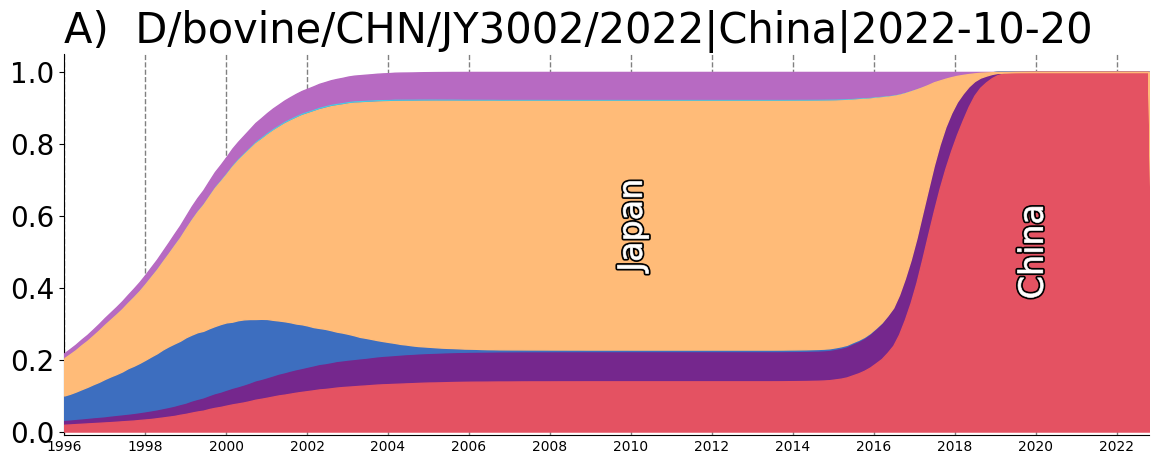

D/bovine/CHN/JY3242/2023|China|2023-02-10


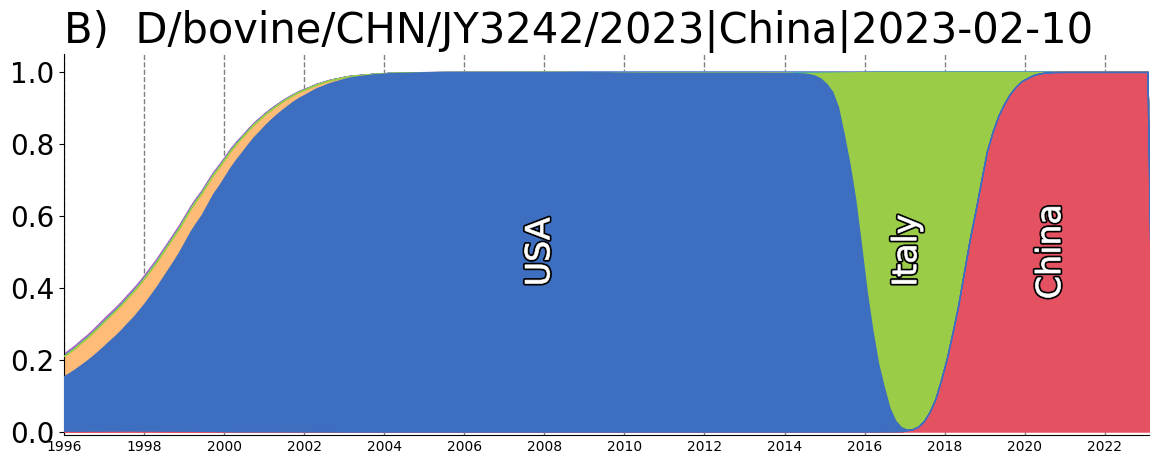

D/bovine/Denmark/3313408142-6/2020|Denmark|2020-01-08


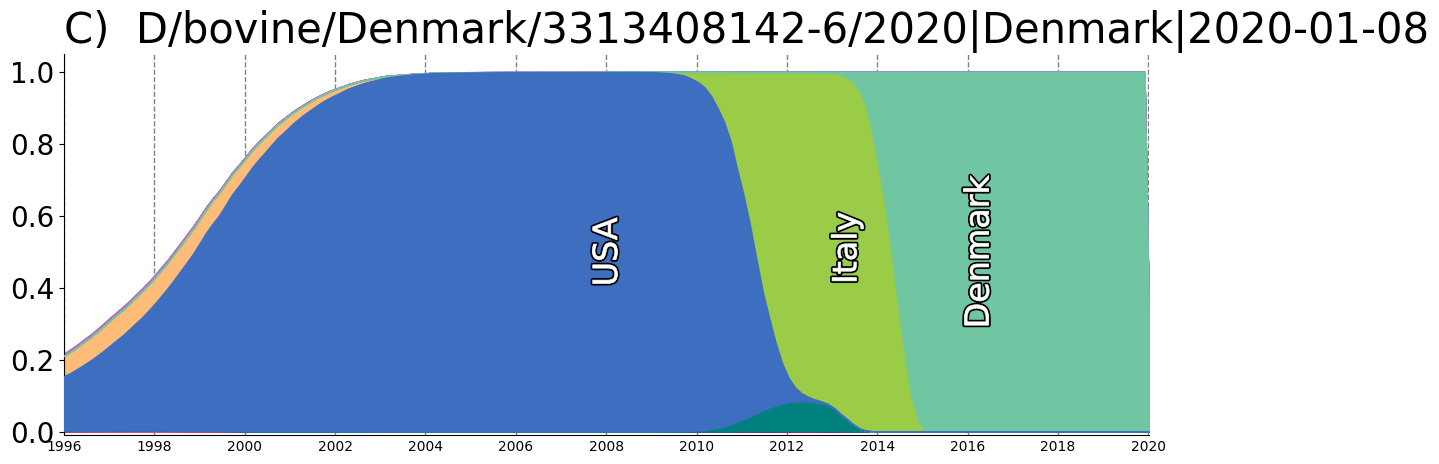

D/bovine/France/B18D/2018|France|2018-02-28


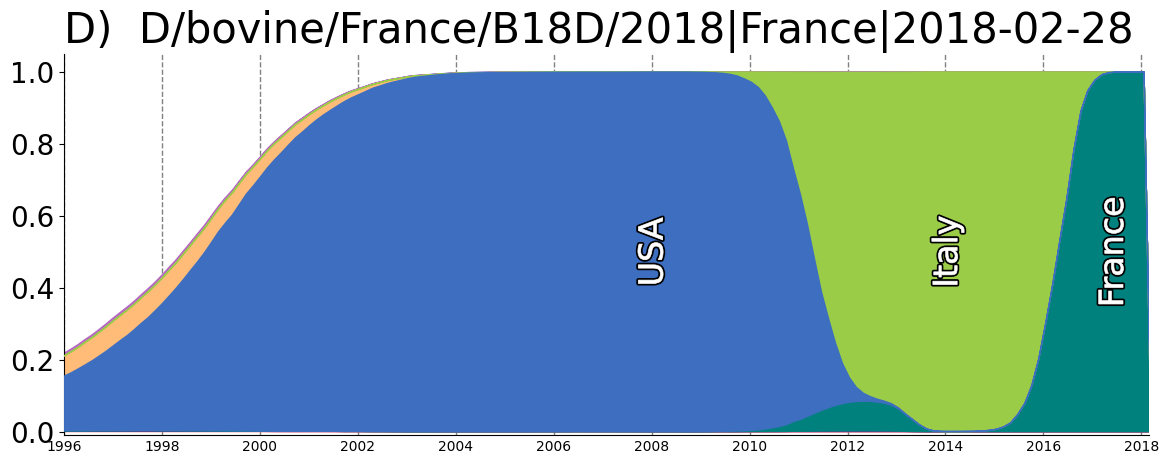

D/swine/Netherlands/PS-497/2021|Netherlands|2021-03-10


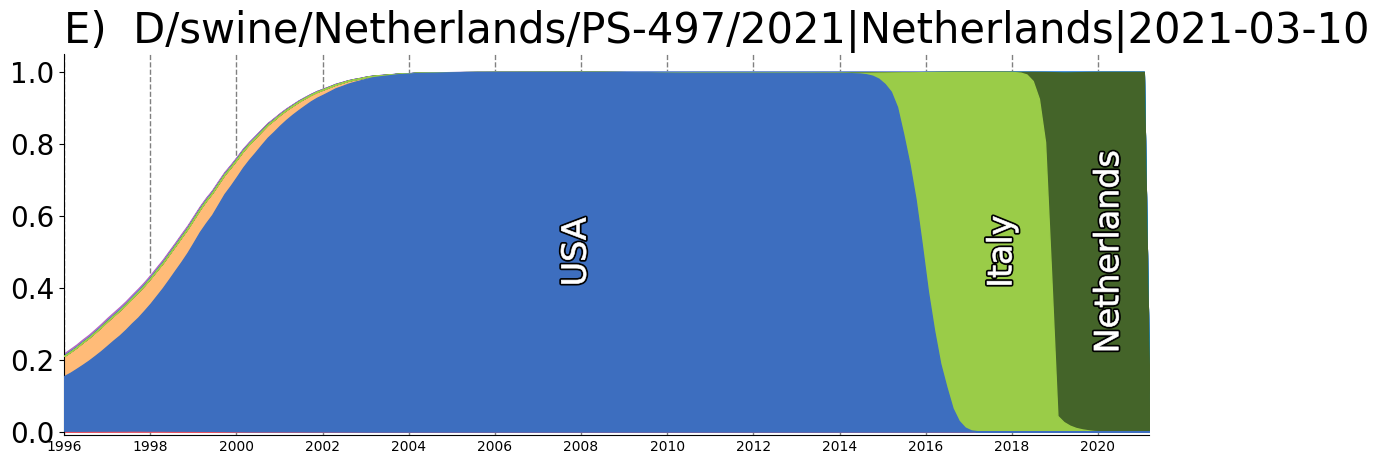

In [5]:
history = {}
locations = ['China', 'Turkey', 'Sweden', 'France', 'USA', 'Japan', 'Italy', 'Netherlands', 'Denmark', 'Namibia', 'Canada', 'United_Kingdom', 'Mexico', 'Australia']

for tip_idx, tip in enumerate(sorted(ancestry[gene])):  ## tip
    print(tip)
    fig = plt.figure(figsize=(14, 10), facecolor='w') 
    gs = gridspec.GridSpec(2, 1, height_ratios=[7, 7], hspace=0.02)
    
    for g, gene in enumerate(['genome']):  ## Only use 'genome' now
        aln = gene.upper()  # Since we removed 'gp', only 'genome' will be here
            
        ax = fig.add_subplot(gs[g])  # Now using 2 rows, 1 column grid (axes are placed in rows)
        
        stack = []
        for tp in timeline:  ## timepoint
            locs = [locations[int(i)] for i in ancestry[gene][tip][tp] if i != 'None']
            mcmclen = len(ancestry[gene][tip][tp])
            prob_area = [locs.count(loc) / float(mcmclen) if locs.count(loc) > 0 else 0.0 for loc in locations]
            stack.append(prob_area)
        
        trajectory = np.array(stack).T
        for l, loc in enumerate(locations):
            if max(trajectory[l]) >= 0.2:
                idx = np.argmax(trajectory[l])
                x = float(timeline[idx])
                y = sum(trajectory[:l, idx])
                ha = 'center'
                va = 'center'
                effects = [path_effects.Stroke(linewidth=3, foreground='k'),
                           path_effects.Stroke(linewidth=0.5, foreground='w')]  ## black text, white outline
                
                if loc == tip.split('|')[1]:
                    ha = 'right'
                    
                if y + trajectory[l][idx] > 0.99 and trajectory[l][idx] < 0.5:
                    va = 'top'
                    y += trajectory[l][idx] / 2.0
                # ax.text(x, y + trajectory[l][idx] / 2.0, map_to_actual[loc], size=24, rotation=90,
                #         ha=ha, va=va, path_effects=effects)
                ax.text(x, y + trajectory[l][idx] / 2.0, loc, size=24, rotation=90,
                        ha=ha, va=va, color='w', path_effects=effects, zorder=1000000)
        
        stack = ax.stackplot(list(map(float, timeline)), trajectory,
                             labels=locations, edgecolor='slategrey', lw=1, **{'zorder': 1000})
        for p, pols in enumerate(stack):
            pols.set_facecolor(state_color[pols.get_label()])
            pols.set_edgecolor(state_color[pols.get_label()])
            pols.set_zorder(sum(trajectory[p]))
        
        ax.tick_params(axis='x', labelsize=26)
        ax.tick_params(axis='y', labelsize=20)
        # ax.text(0.01, 0.98, aln, size=28, va='top', transform=ax.transAxes)
        if g == 0:
            ax.text(0.0, 1.03, '%s)  %s' % ('ABCDE'[tip_idx], tip), size=30, transform=ax.transAxes)
            ax.tick_params(axis='x', size=0, labelsize=0)
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
        
        timelabels =  ['%d-01-01' % y for y in range(1996, 2025, 2)]  # Every 2 years

        ax.set_xticks([bt.decimalDate(y + '-01-01') for y in map(str, range(1996, 2025, 2))])
        [ax.axvline(bt.decimalDate('%d-01-01' % y), color='grey', ls='--', lw=1, zorder=0) for y in range(1996, 2025, 2)]
        
        if g == 0:
            ax.set_xticklabels([bt.convertDate(x, '%Y-%m-%d', '%Y') for x in timelabels], size=10)
            [ax.spines[edge].set_visible(False) for edge in ['top', 'right']]
        else:
            ax.set_ylabel('location\nposterior probability', size=28)
            ax.set_xticklabels([])
            [ax.spines[edge].set_visible(False) for edge in ['top', 'bottom', 'right']]
        
        ax.set_xlim(bt.decimalDate('1996-01-01'), bt.decimalDate(tip.split('|')[-1]))
        ax.set_ylim(-0.01, 1.05)
        
        
    # plt.savefig('migration%s.png' % ('ABCDE'[tip_idx]), dpi=300, bbox_inches='tight')
    plt.show()
